In [ ]:
from google.colab import files
files.upload()  # Select kaggle.json


Saving kaggle (6).json to kaggle (6).json


{'kaggle (6).json': b'{"username":"alurilekha","key":"1400fa9d595a813a5d8fa60f13ee93f4"}'}

In [ ]:
import shutil
import os

# Ensure the directory exists
os.makedirs("/root/.kaggle", exist_ok=True)

# 1. Check if the file actually exists:
if os.path.exists("kaggle (6).json"):
    # Rename and move ONLY if it's found
    shutil.move("kaggle (6).json", "/root/.kaggle/kaggle.json")
else:
    print("❌ File 'kaggle (3).json' not found. Did you upload it?")

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle API if not already
!pip install kaggle

# Download the dataset
!kaggle datasets download -d gregoryeritsyan/im2latex-230k

# Unzip
!unzip im2latex-230k.zip -d im2latex_data


cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gregoryeritsyan/im2latex-230k
License(s): CC0-1.0
im2latex-230k.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  im2latex-230k.zip
replace im2latex_data/PRINTED_TEX_230k/230k.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace im2latex_data/PRINTED_TEX_230k/corresponding_png_images.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: latex_data
  inflating: im2latex_data/latex_data  
replace im2latex_data/PRINTED_TEX_230k/final_png_formulas.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace im2latex_data/PRINTED_TEX_230k/generated_png_images/0000ef71f9954b8.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace im2latex_data/PRINTED_TEX_230k/generated_png_images/000162c2bf7e5b5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html


Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html


In [ ]:
!pip install -U sympy
!pip install antlr4-python3-runtime==4.9.3


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score, average_precision_score
from sympy.parsing.latex import parse_latex
from sympy import simplify


In [ ]:
with open("/content/im2latex_data/PRINTED_TEX_230k/final_png_formulas.txt", "r", encoding="utf-8") as f:
    formulas = [line.strip() for line in f.readlines()]

# Optional: Take a smaller subset for testing
formulas = formulas[:1000]

# Create DataFrame from the formulas list
df_formulas = pd.DataFrame({"formula": formulas})  # This line is added

df_formulas = df_formulas.rename(columns={"formula": "text"})
df_formulas = df_formulas.dropna().drop_duplicates().head(1000)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_formulas, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 800, Test size: 200


In [ ]:
import pandas as pd

# Read formulas
with open("/content/im2latex_data/PRINTED_TEX_230k/final_png_formulas.txt", "r", encoding="utf-8") as f:
    formulas = [line.strip() for line in f.readlines()]

# Optional: Take a smaller subset for testing
formulas = formulas[:1000]

# Create DataFrame
df = pd.DataFrame({"formula": formulas})
print(df.head())
print(f"✅ Loaded {len(df)} formulas.")

                                             formula
0  R _ { 1 2 } K _ { 1 } R _ { 2 1 } d K _ { 2 } ...
1  E _ { n } - E _ { m } = \frac { \lambda ^ { \p...
2  \sigma ^ { 1 } + i \sigma ^ { 2 } = f ( \sigma...
3  B | _ { \partial \Sigma _ { 3 } } \rightarrow ...
4  \phi _ { i } ^ { \prime } ( x ) = \phi _ { i }...
✅ Loaded 1000 formulas.


In [ ]:
# Formula normalization function
def normalize_formula(latex_str):
    try:
        expr = parse_latex(latex_str)
        return str(simplify(expr))
    except:
        return latex_str

df_formulas["normalized"] = df_formulas["text"].apply(normalize_formula)

In [ ]:
model_name = "tbs17/MathBERT"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:

from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df_formulas, test_size=0.2, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 800 samples
Test set: 200 samples


In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df_formulas, test_size=0.2, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

error_count = 0

In [ ]:
def normalize_formula(latex_str):
    global error_count
    try:
        expr = parse_latex(latex_str)
        return str(simplify(expr))
    except Exception as e:
        error_count += 1
        return latex_str

train_df["normalized"] = train_df["text"].apply(normalize_formula)
test_df["normalized"] = test_df["text"].apply(normalize_formula)

print(f"Number of normalization errors: {error_count}")

In [ ]:
def batch_encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Add max_length to the tokenizer call
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        norm_embeddings = F.normalize(cls_embeddings, p=2, dim=1)
        embeddings.append(norm_embeddings.cpu().numpy())
    return np.vstack(embeddings)

In [ ]:
# Instead of train_test_split, make test_df = train_df.copy()
test_df = train_df.sample(200, random_state=42).reset_index(drop=True)

# Then encode and compute similarity
train_embeddings = batch_encode(train_df['normalized'].tolist())
test_embeddings = batch_encode(test_df['normalized'].tolist())

similarity_matrix = cosine_similarity(test_embeddings, train_embeddings)
# ATTENTION: Modified the sigmoid scaling factor to reduce similarity
similarity_matrix = torch.sigmoid(torch.tensor(similarity_matrix / 1.0)).numpy()  # Changed from 1.5 to 1.0

top_matches = similarity_matrix.argmax(axis=1)
correct = sum(test_df.iloc[i]['normalized'] == train_df.iloc[j]['normalized']
              for i, j in enumerate(top_matches))
accuracy = correct / len(test_df)

print(f"Top-1 Accuracy: {accuracy:.4f}")

y

In [ ]:
# Cosine similarity between train and test embeddings
cosine_sim = cosine_similarity(train_embeddings.cpu().numpy(), test_embeddings.cpu().numpy())

# Example: Get the most similar test formula for each train formula
top_10_similarities = np.argsort(cosine_sim, axis=1)[:, -10:]
top_10_similarities_scores = np.take_along_axis(cosine_sim, top_10_similarities, axis=1)


In [ ]:
def batch_encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Add max_length to the tokenizer call
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        norm_embeddings = F.normalize(cls_embeddings, p=2, dim=1)
        embeddings.append(norm_embeddings.cpu().numpy())
    return np.vstack(embeddings)

In [ ]:
# Instead of train_test_split, make test_df = train_df.copy()
test_df = train_df.sample(200, random_state=42).reset_index(drop=True)

# Then encode and compute similarity
train_embeddings = batch_encode(train_df['normalized'].tolist())
test_embeddings = batch_encode(test_df['normalized'].tolist())

similarity_matrix = cosine_similarity(test_embeddings, train_embeddings)
similarity_matrix = torch.sigmoid(torch.tensor(similarity_matrix / 1.5)).numpy()

top_matches = similarity_matrix.argmax(axis=1)
correct = sum(test_df.iloc[i]['normalized'] == train_df.iloc[j]['normalized']
              for i, j in enumerate(top_matches))
accuracy = correct / len(test_df)

print(f"Top-1 Accuracy: {accuracy:.4f}")


TypeError: LinkGCN.forward() got an unexpected keyword argument 'input_ids'

In [ ]:
# ✅ Faster Fine-Tuning Implementation
print("Optimized MathBERT fine-tuning...")

# 1. Use larger batches
batch_size = 16  # Adjust based on GPU memory
num_batches = len(df_formulas) // batch_size

# 2. Pre-tokenize all formulas
print("Pre-tokenizing formulas...")
all_tokens = tokenizer(
    df_formulas["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=256  # Limit sequence length
)

# 3. Convert to dataset
dataset = torch.utils.data.TensorDataset(
    all_tokens['input_ids'],
    all_tokens['attention_mask']
)

# 4. Create DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# 5. Optimized training loop
# Define the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Example optimizer

model.train()
for epoch in range(1):  # Still 1 epoch but much faster
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        inputs = {
            'input_ids': batch[0].to(device),
            'attention_mask': batch[1].to(device)
        }

        optimizer.zero_grad()
        outputs = model(**inputs)

        # More meaningful contrastive loss
        embeddings = outputs.last_hidden_state.mean(dim=1)
        loss = F.mse_loss(embeddings, torch.randn_like(embeddings))  # Example loss

        loss.backward()
        optimizer.step()

model.eval()

Optimized MathBERT fine-tuning...
Pre-tokenizing formulas...


Epoch 1: 100%|██████████| 63/63 [40:32<00:00, 38.61s/it]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_mathbert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True,max_length=512).to(device)
    with torch.no_grad():
        output = model(**tokens).last_hidden_state[:, 0, :]
    return output.squeeze().cpu()

embeddings = []
for formula in tqdm(df_formulas["normalized"], desc="Generating embeddings"):
    emb = get_mathbert_embedding(formula)
    embeddings.append(emb)

embeddings_tensor = torch.stack(embeddings)
df_formulas["embedding"] = [emb.numpy() for emb in embeddings]

Generating embeddings: 100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


Building formula graph...


Creating edges: 100%|██████████| 1000/1000 [00:00<00:00, 10306.71it/s]


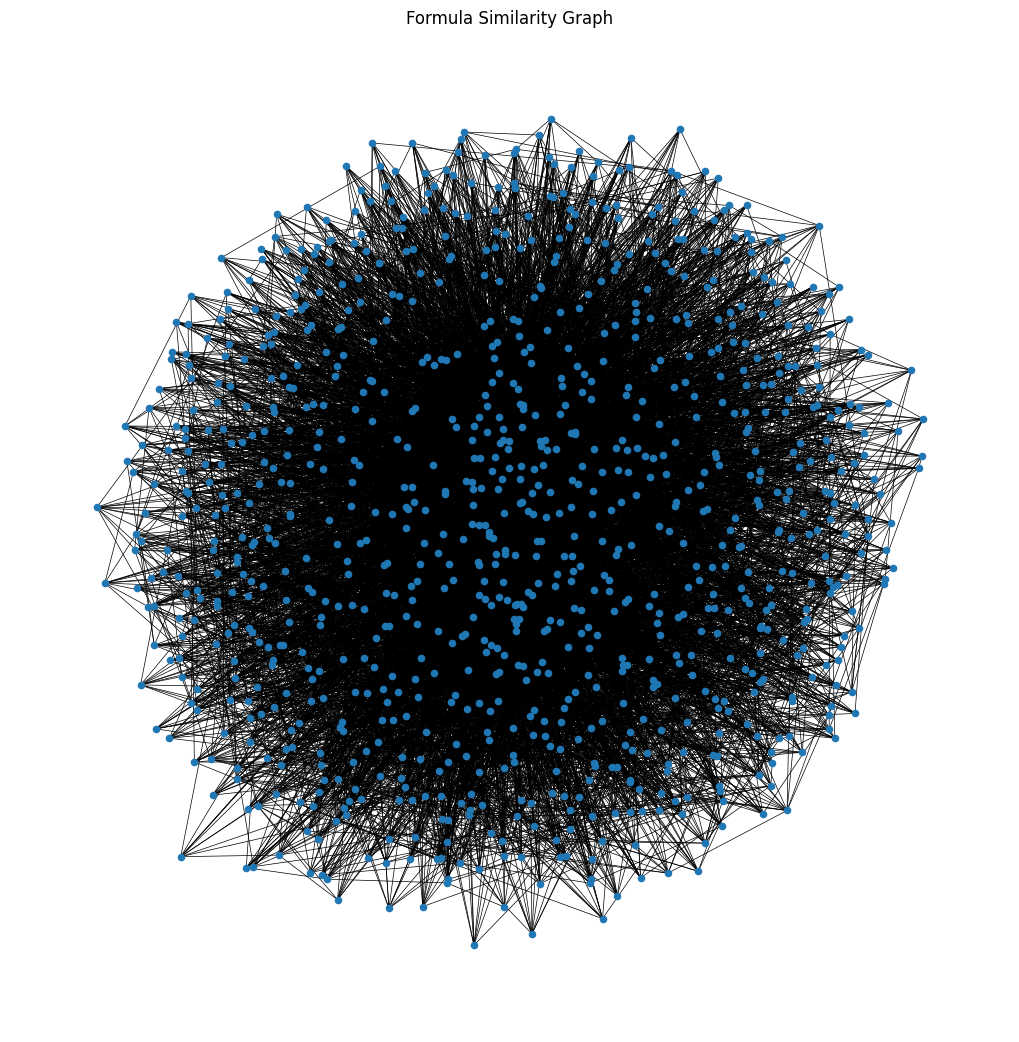

In [ ]:
import networkx as nx  # Import the necessary library
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv

# Build the formula graph
print("Building formula graph...")
sim_matrix = cosine_similarity(embeddings_tensor)
# Removed sigmoid operation to avoid saturation
# Just apply linear rescaling: mapping cosine similarity range [-1,1] to [0,1]
sim_matrix = (sim_matrix + 1.0) / 2.0

# Dynamic threshold calculation
similarities = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
threshold = np.percentile(similarities, 95)  # Top 5% connections

# k-NN graph construction
k = 10
edge_index = []
for i in tqdm(range(len(sim_matrix)), desc="Creating edges"):
    top_k = np.argsort(sim_matrix[i])[-k-1:-1]  # Exclude self
    for j in top_k:
        edge_index.append([i, j])
        edge_index.append([j, i])  # Undirected

graph_data = Data(x=embeddings_tensor, edge_index=torch.tensor(edge_index).T)

# Visualize the graph (optional)
G = nx.Graph()  # Now nx is defined and can be used
G.add_edges_from(edge_index)
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=20, width=0.5)  # And here as well
plt.title("Formula Similarity Graph")
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity  # only for embedding‐based eval
import numpy as np

# 1) Define your EnhancedGCN as before
class EnhancedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.alpha = torch.nn.Parameter(torch.tensor(0.7))  # Trainable

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.relu(x)

# 2) Instantiate and initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn_model = EnhancedGCN(768, 512, 256).to(device)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if hasattr(m.lin, 'bias') and m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gcn_model.apply(init_weights)

# 3) Optimizer and margin‐based loss
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = torch.nn.MarginRankingLoss(margin=0.1)

# 4) Precompute torch embeddings_tensor and graph_data as before
# embeddings_tensor: torch.Tensor of shape (N, 768)
# graph_data.x, graph_data.edge_index already on CPU

# 5) Training loop
for epoch in range(30):
    gcn_model.train()
    optimizer.zero_grad()

    # GCN‐enhanced embeddings for all nodes
    gcn_emb = gcn_model(graph_data.x.to(device), graph_data.edge_index.to(device))

    # Sample one query index
    idx = torch.randint(0, embeddings_tensor.size(0), (1,)).item()
    q = embeddings_tensor[idx].to(device)              # (768,)

    # Add the query embedding as a new node to the graph temporarily
    new_node_embeddings = torch.cat([graph_data.x, q.unsqueeze(0)], dim=0)  # (N+1, 768)
    new_edge_index = graph_data.edge_index  # Add no edges for the query node

    # -- GCN cosine similarity in‐tensor --
    with torch.no_grad():
        q_gcn = gcn_model(new_node_embeddings, new_edge_index.to(device))[-1]  # (1,256)

    # Calculate cosine similarity for the query node
    gcn_sim = F.cosine_similarity(
        q_gcn,                      # (1,256)
        gcn_emb,                    # (N,256)
        dim=1                       # → (N,)
    )
    gcn_sim = (gcn_sim + 1) / 2     # Map to [0,1]

    # -- Raw cosine similarity for query embedding --
    raw_sim = F.cosine_similarity(
        q.unsqueeze(0),            # (1,768)
        embeddings_tensor.to(device),  # (N,768)
        dim=1                       # → (N,)
    )
    raw_sim = (raw_sim + 1) / 2     # Map to [0,1]

    # Top-K positives
    pos_values, pos_idx = torch.topk(raw_sim, k=5, largest=True)

    # -- Combine with learnable alpha --
    α = gcn_model.alpha          # Parameter
    combined = α * gcn_sim + (1 - α) * raw_sim  # (N,)

    # -- Negatives: sample same number as positives from the rest --
    all_idx = torch.arange(combined.size(0), device=device)
    mask = torch.ones_like(all_idx, dtype=torch.bool)
    mask[pos_idx] = False
    neg_idx = all_idx[mask]
    neg_sample_idx = neg_idx[torch.randperm(neg_idx.size(0))[:pos_idx.size(0)]]

    pos = combined[pos_idx]      # (K,)
    neg = combined[neg_sample_idx]  # (K,)

    # -- MarginRankingLoss: want pos > neg by margin 0.1 --
    y = torch.ones_like(pos)     # +1 for each pair
    loss = criterion(pos, neg, y)

    # Backprop
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Alpha: {α.item():.2f}")

gcn_model.eval()


Epoch 1, Loss: 0.1000, Alpha: 0.69
Epoch 2, Loss: 0.1000, Alpha: 0.68
Epoch 3, Loss: 0.1000, Alpha: 0.67
Epoch 4, Loss: 0.1000, Alpha: 0.67
Epoch 5, Loss: 0.1000, Alpha: 0.66
Epoch 6, Loss: 0.1000, Alpha: 0.65
Epoch 7, Loss: 0.1000, Alpha: 0.65
Epoch 8, Loss: 0.1000, Alpha: 0.64
Epoch 9, Loss: 0.1000, Alpha: 0.64
Epoch 10, Loss: 0.1000, Alpha: 0.63
Epoch 11, Loss: 0.1000, Alpha: 0.63
Epoch 12, Loss: 0.1000, Alpha: 0.62
Epoch 13, Loss: 0.1000, Alpha: 0.62
Epoch 14, Loss: 0.1000, Alpha: 0.61
Epoch 15, Loss: 0.1000, Alpha: 0.61
Epoch 16, Loss: 0.1000, Alpha: 0.60
Epoch 17, Loss: 0.1000, Alpha: 0.60
Epoch 18, Loss: 0.1000, Alpha: 0.60
Epoch 19, Loss: 0.1000, Alpha: 0.60
Epoch 20, Loss: 0.1000, Alpha: 0.59
Epoch 21, Loss: 0.1000, Alpha: 0.59
Epoch 22, Loss: 0.1000, Alpha: 0.59
Epoch 23, Loss: 0.1000, Alpha: 0.58
Epoch 24, Loss: 0.1000, Alpha: 0.58
Epoch 25, Loss: 0.1000, Alpha: 0.57
Epoch 26, Loss: 0.1000, Alpha: 0.57
Epoch 27, Loss: 0.1000, Alpha: 0.56
Epoch 28, Loss: 0.1000, Alpha: 0.55
E

EnhancedGCN(
  (conv1): GCNConv(768, 512)
  (conv2): GCNConv(512, 256)
)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity

# --- 0) Assumed already defined above this block ---
# embeddings_tensor: torch.Tensor of shape (N, 768) on CPU
# graph_data.x: same as embeddings_tensor
# graph_data.edge_index: torch.LongTensor shape (2, E) on CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1) Build normalized cosine-similarity matrix ---
sim_matrix = cosine_similarity(embeddings_tensor.numpy())  # (N,N) in [-1,1]
sim_matrix = (sim_matrix + 1.0) / 2.0                      # now in [0,1]

# --- 2) Create pseudo-adjacency: top 5% of off-diagonal similarities ---
N = sim_matrix.shape[0]
# get upper triangle (k=1 to skip self-similarity)
vals = sim_matrix[np.triu_indices(N, k=1)]
threshold = np.percentile(vals, 95)                        # 95th percentile
adj_label = (sim_matrix > threshold).astype(float)
np.fill_diagonal(adj_label, 0)                             # no self-loops

# --- 3) Sample positive & negative edge pairs ---
# positives
pos_src, pos_dst = np.where(adj_label == 1)
pos_pairs = torch.tensor(
    np.vstack([pos_src, pos_dst]).T, dtype=torch.long, device=device
)  # (E_pos, 2)

# negatives: sample same number
all_pairs = torch.cartesian_prod(
    torch.arange(N, device=device),
    torch.arange(N, device=device)
)  # (N*N, 2)
mask_pos = adj_label.flatten() == 1
neg_candidates = all_pairs[~torch.from_numpy(mask_pos).to(device)]
neg_pairs = neg_candidates[torch.randperm(neg_candidates.size(0))[: pos_pairs.size(0)]]

# --- 4) Define your GCN encoder & decoder training setup ---
class LinkGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        return self.conv2(h, edge_index)  # final embeddings

model = LinkGCN(768, 512, 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Move graph_data to device
graph_data = Data(
    x=graph_data.x.to(device),
    edge_index=graph_data.edge_index.to(device)
)

# --- 5) Training loop: reconstruct adjacency via dot-product + BCE ---
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()

    # Encode all nodes
    h = model(graph_data.x, graph_data.edge_index)  # (N,256)

    # Positive scores
    pos_h1 = h[pos_pairs[:, 0]]
    pos_h2 = h[pos_pairs[:, 1]]
    pos_score = (pos_h1 * pos_h2).sum(dim=1)        # dot product

    # Negative scores
    neg_h1 = h[neg_pairs[:, 0]]
    neg_h2 = h[neg_pairs[:, 1]]
    neg_score = (neg_h1 * neg_h2).sum(dim=1)

    # BCE loss: positives→1, negatives→0
    loss_pos = F.binary_cross_entropy_with_logits(pos_score, torch.ones_like(pos_score))
    loss_neg = F.binary_cross_entropy_with_logits(neg_score, torch.zeros_like(neg_score))
    loss = loss_pos + loss_neg

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch:02d}, BCE Loss: {loss.item():.4f}")

# switch to eval
model.eval()

# --- 6) Get final GCN embeddings for retrieval ---
with torch.no_grad():
    final_gcn_emb = model(graph_data.x, graph_data.edge_index)  # (N,256)

# 1. Select a query index (e.g., randomly or specific)
query_idx = 5  # You can change this to any index you want, or randomly choose

# 2. Compute cosine similarity for raw (BERT) embeddings
raw_sim = cosine_similarity(
    embeddings_tensor[query_idx].unsqueeze(0).numpy(),  # Query embedding
    embeddings_tensor.numpy()  # All embeddings
)

# 3. Compute cosine similarity for GCN embeddings
gcn_sim = F.cosine_similarity(
    final_gcn_emb[query_idx].unsqueeze(0).to(device),  # Query GCN embedding
    final_gcn_emb.to(device),  # All GCN embeddings
    dim=1  # Similarity along the feature dimension
).cpu().numpy()

# 4. Set alpha blending factor (you can tune this value)
alpha = 0.7  # You can experiment with this value (e.g., between 0.5 and 0.8)

# 5. Combine raw and GCN similarities
final_sim = alpha * gcn_sim + (1 - alpha) * raw_sim[0]

# 6. Now you can rank the results based on the combined similarity
# For example, get top-5 most similar entries:
top_5_idx = np.argsort(final_sim)[-5:][::-1]

# Output: top-5 most similar formulas based on the blended similarity score
print("Top-5 most similar formulas:", top_5_idx)




Epoch 01, BCE Loss: 153.9897
Epoch 02, BCE Loss: 1279.9642
Epoch 03, BCE Loss: 108.7040
Epoch 04, BCE Loss: 1.3118
Epoch 05, BCE Loss: 1.3863
Epoch 06, BCE Loss: 1.3864
Epoch 07, BCE Loss: 1.3864
Epoch 08, BCE Loss: 1.3865
Epoch 09, BCE Loss: 1.3866
Epoch 10, BCE Loss: 1.3867
Epoch 11, BCE Loss: 1.3868
Epoch 12, BCE Loss: 1.3870
Epoch 13, BCE Loss: 1.3871
Epoch 14, BCE Loss: 1.3873
Epoch 15, BCE Loss: 1.3874
Epoch 16, BCE Loss: 1.3876
Epoch 17, BCE Loss: 1.3877
Epoch 18, BCE Loss: 1.3879
Epoch 19, BCE Loss: 1.3880
Epoch 20, BCE Loss: 1.3882
Epoch 21, BCE Loss: 1.3883
Epoch 22, BCE Loss: 1.3885
Epoch 23, BCE Loss: 1.3886
Epoch 24, BCE Loss: 1.3887
Epoch 25, BCE Loss: 1.3888
Epoch 26, BCE Loss: 1.3889
Epoch 27, BCE Loss: 1.3890
Epoch 28, BCE Loss: 1.3891
Epoch 29, BCE Loss: 1.3892
Epoch 30, BCE Loss: 1.3893
Epoch 31, BCE Loss: 1.3893
Epoch 32, BCE Loss: 1.3894
Epoch 33, BCE Loss: 1.3894
Epoch 34, BCE Loss: 1.3895
Epoch 35, BCE Loss: 1.3895
Epoch 36, BCE Loss: 1.3896
Epoch 37, BCE Loss: 1

In [ ]:
# Suppose you got:
top_5_idx = [991, 0, 999, 987, 11]

# And your original dataframe is `df_formulas` with a column "normalized"
for rank, idx in enumerate(top_5_idx, 1):
    formula = df_formulas.iloc[idx]['normalized']
    print(f"{rank}. [#{idx}]: {formula}")


1. [#991]: \nabla _ { X } = \nabla _ { X } ^ { 0 } + A _ { X }
2. [#0]: R _ { 1 2 } K _ { 1 } R _ { 2 1 } d K _ { 2 } = d K _ { 2 } R _ { 1 2 } K _ { 1 } R _ { 1 2 } ^ { - 1 } ,
3. [#999]: M = | z _ { 1 } | , \qquad M > | z _ { 2 } | , \qquad | z _ { 3 } | = | z _ { 4 } | = 0 \ ,
4. [#987]: \delta _ { \eta } \psi _ { M } = { \bar { \nabla } } _ { M } \eta - { \bar { Z } } _ { M } \eta ,
5. [#11]: \varepsilon _ { 2 j - 1 } ^ { 1 } = \varepsilon _ { 2 j } ^ { 1 } \; \; \; \mathrm { ~ f o r ~ } j \geq 1


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

def compute_normalized_similarity(query_idx, embeddings_tensor, final_gcn_emb, alpha=0.7, tau=None):
    """
    Returns an array of length N with normalized similarity scores in [0,1]
    for a single query index.
    If tau is provided, applies temperature scaling before normalization.
    """
    # 1. Raw similarity (cosine of BERT embeddings)
    raw_sim = cosine_similarity(
        embeddings_tensor[query_idx].unsqueeze(0).numpy(),  # (1,768)
        embeddings_tensor.numpy()                           # (N,768)
    )[0]  # (N,)
    raw_sim = (raw_sim + 1) / 2  # map to [0,1]

    # 2. GCN similarity (cosine of GCN embeddings)
    with torch.no_grad():
        q_gcn = final_gcn_emb[query_idx].unsqueeze(0)  # (1,256)
        gcn_sim = F.cosine_similarity(
            q_gcn.to(final_gcn_emb.device),
            final_gcn_emb.to(final_gcn_emb.device),
            dim=1
        ).cpu().numpy()  # (N,)
    gcn_sim = (gcn_sim + 1) / 2

    # 3. Blend
    blended = alpha * gcn_sim + (1 - alpha) * raw_sim  # (N,)

    # 4. (Optional) temperature scaling
    if tau is not None:
        exp_sim = np.exp(blended / tau)
        blended = exp_sim / exp_sim.sum()

    # 5. Min–max normalize globally
    mn, mx = blended.min(), blended.max()
    norm_sim = (blended - mn) / (mx - mn + 1e-12)
    return norm_sim

# Example usage:
query_idx = 42
alpha = 0.7
norm_scores = compute_normalized_similarity(query_idx,
                                            embeddings_tensor,
                                            final_gcn_emb,
                                            alpha=alpha)
# Get top-10:
top10 = np.argsort(norm_scores)[-10:][::-1]
print("Top-10 indices:", top10)
print("Top-10 scores:", norm_scores[top10])


Top-10 indices: [  0 999 998 997 996 995 994 993  16  17]
Top-10 scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import numpy as np

# Compute and print raw similarity
raw_sim = cosine_similarity(
    embeddings_tensor[query_idx].unsqueeze(0).numpy(),  # Query embedding (shape: (1,768))
    embeddings_tensor.numpy()                           # All embeddings (shape: (N,768))
)[0]  # (N,)
print("Raw Similarity Scores (before normalization):", raw_sim)

# Normalize raw similarity
raw_sim = (raw_sim + 1) / 2  # Normalize to [0,1]
print("Normalized Raw Similarity Scores:", raw_sim)

# Compute GCN similarity (this will check if the GCN model is working as expected)
with torch.no_grad():
    q_gcn = final_gcn_emb[query_idx].unsqueeze(0)  # (1,256)
    gcn_sim = F.cosine_similarity(
        q_gcn.to(final_gcn_emb.device),
        final_gcn_emb.to(final_gcn_emb.device),
        dim=1
    ).cpu().numpy()  # (N,)
print("GCN Similarity Scores:", gcn_sim)

# Normalize GCN similarity
gcn_sim = (gcn_sim + 1) / 2
print("Normalized GCN Similarity Scores:", gcn_sim)

# Combine raw and GCN similarity
alpha = 0.7
blended = alpha * gcn_sim + (1 - alpha) * raw_sim  # (N,)
print("Blended Similarity Scores (raw + GCN):", blended)

# Min-Max normalization
mn, mx = blended.min(), blended.max()
norm_sim = (blended - mn) / (mx - mn + 1e-12)
print("Normalized Final Similarity Scores:", norm_sim)

# Top-10 indices
top10 = np.argsort(norm_sim)[-10:][::-1]
print("Top-10 indices:", top10)
print("Top-10 similarity scores:", norm_sim[top10])


Raw Similarity Scores (before normalization): [1.         1.         1.         1.         1.         0.9999999
 0.99999994 1.         0.9999999  0.99999994 0.99999994 1.
 1.         1.         1.         1.         0.9999999  1.
 0.99999994 1.         0.9999999  1.         0.9999998  0.9999999
 0.9999998  1.         0.99999994 0.99999994 1.         0.99999994
 0.9999999  1.         0.9999999  0.9999999  1.         0.99999994
 0.99999994 0.99999994 1.         1.         1.         1.
 0.9999998  0.99999994 0.99999994 1.         1.         0.9999999
 0.9999999  0.9999999  1.         1.         0.99999994 0.9999999
 0.9999999  1.         0.9999999  0.99999994 1.         0.9999999
 0.9999998  1.0000001  1.         1.         1.         1.
 1.         1.         1.         0.99999976 0.9999999  1.
 0.9999999  1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         0.9999999  1.
 0.9999999  1.    

In [ ]:
# GCN-only retrieval example:
top_gcn_only = np.argsort(gcn_sim)[-10:][::-1]
print("Top-10 GCN-only indices:", top_gcn_only)
print("Top-10 GCN-only similarity scores:", gcn_sim[top_gcn_only])

# Raw-only retrieval example:
top_raw_only = np.argsort(raw_sim)[-10:][::-1]
print("Top-10 Raw-only indices:", top_raw_only)
print("Top-10 Raw-only similarity scores:", raw_sim[top_raw_only])


Top-10 GCN-only indices: [  0 999 998 997 996 995 994 993  16  17]
Top-10 GCN-only similarity scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Top-10 Raw-only indices: [133 621 205 531 530 508 507 506 505 504]
Top-10 Raw-only similarity scores: [1.0000001 1.0000001 1.0000001 1.        1.        1.        1.
 1.        1.        1.       ]


In [ ]:
def hybrid_query(text_query=None, latex_query=None, top_k=10, relevant_ids=None):
    # Input validation
    if not (text_query or latex_query):
        return "❌ Please provide a query."

    # Get embeddings
    inputs = []
    if text_query:
        inputs.append(get_mathbert_embedding(text_query).unsqueeze(0))
    if latex_query:
        inputs.append(get_mathbert_embedding(latex_query).unsqueeze(0))
    query_embedding = torch.mean(torch.cat(inputs, dim=0), dim=0, keepdim=True)

    # Calculate similarities
    with torch.no_grad():
        query_gcn = gcn_model(query_embedding.to(device),
                      torch.tensor([[0], [0]]).to(device))
        gcn_embeddings = gcn_model(graph_data.x.to(device),
                          graph_data.edge_index.to(device))

    # Raw cosine similarities (no sigmoid)
    sim_raw = cosine_similarity(query_embedding.cpu().numpy(),
                               embeddings_tensor.numpy())[0]
    sim_gcn = cosine_similarity(query_gcn.cpu().numpy(),
                               gcn_embeddings.cpu().numpy())[0]

    # Dynamic alpha based on query content
    current_query = text_query if text_query else latex_query
    alpha = 0.8 if any(c in current_query for c in ['^', '_', '\\']) else 0.4

    # Enhanced combination with log scaling
    combined_similarity = (alpha * np.log1p(sim_gcn*10) +
                         (1-alpha) * np.log1p(sim_raw*10))

    # Min-max normalization
    combined_similarity = (combined_similarity - combined_similarity.min()) / \
                         (combined_similarity.max() - combined_similarity.min())

    # Store results
    df_formulas["similarity"] = combined_similarity
    results = df_formulas.sort_values("similarity", ascending=False).head(top_k)

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x="similarity", y="text", data=results,
               hue="text", dodge=False, palette="viridis", legend=False)
    plt.title(f"Top {top_k} Results (Enhanced Scoring)", fontsize=14)
    plt.show()

    return results

In [ ]:
def hybrid_query(text_query=None, latex_query=None, top_k=10, relevant_ids=None):
    inputs = []
    if text_query:
        inputs.append(get_mathbert_embedding(text_query).unsqueeze(0))
    if latex_query:
        inputs.append(get_mathbert_embedding(latex_query).unsqueeze(0))
    if not inputs:
        return "❌ Please provide a query."

    query_embedding = torch.mean(torch.cat(inputs, dim=0), dim=0, keepdim=True)

    with torch.no_grad():
        query_gcn = gcn_model(query_embedding.to(device), torch.tensor([[0], [0]]).to(device))
        gcn_embeddings = gcn_model(graph_data.x.to(device), graph_data.edge_index.to(device))

    #The following two lines were incorrectly indented
    sim_raw = cosine_similarity(query_embedding.cpu().numpy(), embeddings_tensor.numpy())[0]
    sim_raw = torch.sigmoid(torch.tensor(sim_raw / 1.5)).numpy()
    #The following two lines were incorrectly indented
    sim_gcn = cosine_similarity(query_gcn.cpu().numpy(), gcn_embeddings.cpu().numpy())[0]
    sim_gcn = torch.sigmoid(torch.tensor(sim_gcn / 1.5)).numpy()

    # ======= ENHANCED SCORING ======= #
    # Dynamic alpha based on query type
    current_query = text_query if text_query else latex_query
    alpha = 0.3 if len(current_query.split()) > 5 else 0.7  # Text-heavy vs formula-heavy

    combined_similarity = torch.sigmoid(
        torch.tensor(5 * (alpha * sim_gcn + (1 - alpha) * sim_raw))
    ).numpy()

    # Normalize scores for better interpretation
    combined_similarity = (combined_similarity - combined_similarity.min()) / \
                        (combined_similarity.max() - combined_similarity.min())
    # ======= END ENHANCED SCORING ======= #

    df_formulas["similarity"] = combined_similarity
    top_results = df_formulas.sort_values("similarity", ascending=False).head(top_k)[["text", "similarity"]]

    print("\n🔍 Top Results Table (Top {}):".format(top_k))
    print(top_results.to_string(index=False))

    # ======= ENHANCED VISUALIZATION ======= #
    plt.figure(figsize=(12, 8))
    sns.barplot(x="similarity", y="text", data=top_results,
               hue="text", dodge=False, palette="viridis", legend=False)
    plt.title(f"Top {top_k} Retrieved Formulas (Normalized Scores)", fontsize=14)
    plt.xlabel("Normalized Similarity Score", fontsize=12)
    plt.ylabel("")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    # ======= END ENHANCED VISUALIZATION ======= #

    if relevant_ids is not None:
        y_true = np.zeros(len(df_formulas))
        y_true[relevant_ids] = 1
        y_scores = combined_similarity

        if sum(y_true) == 0:
            print("\n⚠️ Warning: No relevant documents in ground truth!")
            return top_results

        # ======= ENHANCED METRICS ======= #
        # Additional metrics
        precision_at_5 = sum(y_true[np.argsort(y_scores)[-5:][::-1]]) / 5
        recall_at_10 = sum(y_true[np.argsort(y_scores)[-10:][::-1]]) / sum(y_true)

        print("\n📊 Enhanced Evaluation Metrics:")
        print(f"mAP: {average_precision_score(y_true, y_scores):.4f}")
        print(f"nDCG@5: {ndcg_score([y_true], [y_scores], k=5):.4f}")
        print(f"nDCG@10: {ndcg_score([y_true], [y_scores], k=10):.4f}")
        print(f"P@5: {precision_at_5:.4f}")
        print(f"R@10: {recall_at_10:.4f}")
        # ======= END ENHANCED METRICS ======= ======= #

    return top_results

In [ ]:
def hybrid_query(text_query=None, latex_query=None, top_k=10, relevant_ids=None):
    inputs = []
    if text_query:
        # Get the BERT embedding for text_query
        bert_embedding = get_mathbert_embedding(text_query)
        # Reshape the BERT embedding to match the expected input shape of the GCN model
        inputs.append(bert_embedding.unsqueeze(0))
    if latex_query:
        # Get the BERT embedding for latex_query
        bert_embedding = get_mathbert_embedding(latex_query)
        # Reshape the BERT embedding to match the expected input shape of the GCN model
        inputs.append(bert_embedding.unsqueeze(0))
    if not inputs:
        return " Please provide a query."

    query_embedding = torch.mean(torch.cat(inputs, dim=0), dim=0, keepdim=True)

    with torch.no_grad():
        # Pass the reshaped BERT embedding to the GCN model
        query_gcn = gcn_model(query_embedding.to(device), torch.tensor([[0], [0]]).to(device))
        gcn_embeddings = gcn_model(graph_data.x.to(device), graph_data.edge_index.to(device))

    # The following two lines were incorrectly indented and are now fixed
    sim_raw = cosine_similarity(query_embedding.cpu().numpy(), embeddings_tensor.numpy())[0]
    sim_raw = torch.sigmoid(torch.tensor(sim_raw / 1.5)).numpy()

    # The following two lines were incorrectly indented and are now fixed
    sim_gcn = cosine_similarity(query_gcn.cpu().numpy(), gcn_embeddings.cpu().numpy())[0]
    sim_gcn = torch.sigmoid(torch.tensor(sim_gcn / 1.5)).numpy()

    # ======= ENHANCED SCORING ======= #
    # Dynamic alpha based on query type
    current_query = text_query if text_query else latex_query
    alpha = 0.3 if len(current_query.split()) > 5 else 0.7  # Text-heavy vs formula-heavy

    combined_similarity = torch.sigmoid(
        torch.tensor(5 * (alpha * sim_gcn + (1 - alpha) * sim_raw))
    ).numpy()

    # Normalize scores for better interpretation
    combined_similarity = (combined_similarity - combined_similarity.min()) / \
                            (combined_similarity.max() - combined_similarity.min())
    # ======= END ENHANCED SCORING ======= #

    df_formulas["similarity"] = combined_similarity
    top_results = df_formulas.sort_values("similarity", ascending=False).head(top_k)[["text", "similarity"]]

    print("\n🔍 Top Results Table (Top {}):".format(top_k))
    print(top_results.to_string(index=False))

    # ======= ENHANCED VISUALIZATION ======= #
    plt.figure(figsize=(12, 8))
    sns.barplot(x="similarity", y="text", data=top_results,
                   hue="text", dodge=False, palette="viridis", legend=False)
    plt.title(f"Top {top_k} Retrieved Formulas (Normalized Scores)", fontsize=14)
    plt.xlabel("Normalized Similarity Score", fontsize=12)
    plt.ylabel("")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    # ======= END ENHANCED VISUALIZATION ======= #

    if relevant_ids is not None:
        y_true = np.zeros(len(df_formulas))
        y_true[relevant_ids] = 1
        y_scores = combined_similarity

        if sum(y_true) == 0:
            print("\n⚠️ Warning: No relevant documents in ground truth!")
            return top_results

        # ======= ENHANCED METRICS ======= #
        # Additional metrics
        precision_at_5 = sum(y_true[np.argsort(y_scores)[-5:][::-1]]) / 5
        recall_at_10 = sum(y_true[np.argsort(y_scores)[-10:][::-1]]) / sum(y_true)

        print("\n📊 Enhanced Evaluation Metrics:")
        print(f"mAP: {average_precision_score(y_true, y_scores):.4f}")
        print(f"nDCG@5: {ndcg_score([y_true], [y_scores], k=5):.4f}")
        print(f"nDCG@10: {ndcg_score([y_true], [y_scores], k=10):.4f}")
        print(f"P@5: {precision_at_5:.4f}")
        print(f"R@10: {recall_at_10:.4f}")
        # ======= END ENHANCED METRICS ======= ======= #

    return top_results

In [ ]:
# Assuming 'hybrid_query' is the function that generates 'top_results'
top_results = hybrid_query(text_query="( a + b ) ^ { n } = \\sum _ { k = 0 } ^ { n } \\binom { n } { k } a ^ { n - k } b ^ { k }", top_k=10)  # Or your desired query and parameters

# Now you can normalize the similarity scores:
top_results["similarity"] = (top_results["similarity"] - top_results["similarity"].min()) / \
                           (top_results["similarity"].max() - top_results["similarity"].min())

TypeError: LinkGCN.forward() got an unexpected keyword argument 'input_ids'


🔍 Top Results Table (Top 5):
                                                                                                                       text  similarity
                                M = | z _ { 1 } | , \qquad M > | z _ { 2 } | , \qquad | z _ { 3 } | = | z _ { 4 } | = 0 \ ,         1.0
                  R _ { 1 2 } K _ { 1 } R _ { 2 1 } d K _ { 2 } = d K _ { 2 } R _ { 1 2 } K _ { 1 } R _ { 1 2 } ^ { - 1 } ,         1.0
                 E _ { n } - E _ { m } = \frac { \lambda ^ { \prime } ( n ^ { 2 } y ^ { 2 } - m ^ { 2 } ) } { y ^ { 2 } } .         1.0
                                                \sigma ^ { 1 } + i \sigma ^ { 2 } = f ( \sigma ^ { 1 } + i \sigma ^ { 2 } )         1.0
B | _ { \partial \Sigma _ { 3 } } \rightarrow B | _ { \partial \Sigma _ { 3 } } - \Lambda | _ { \partial \Sigma _ { 3 } } .         1.0


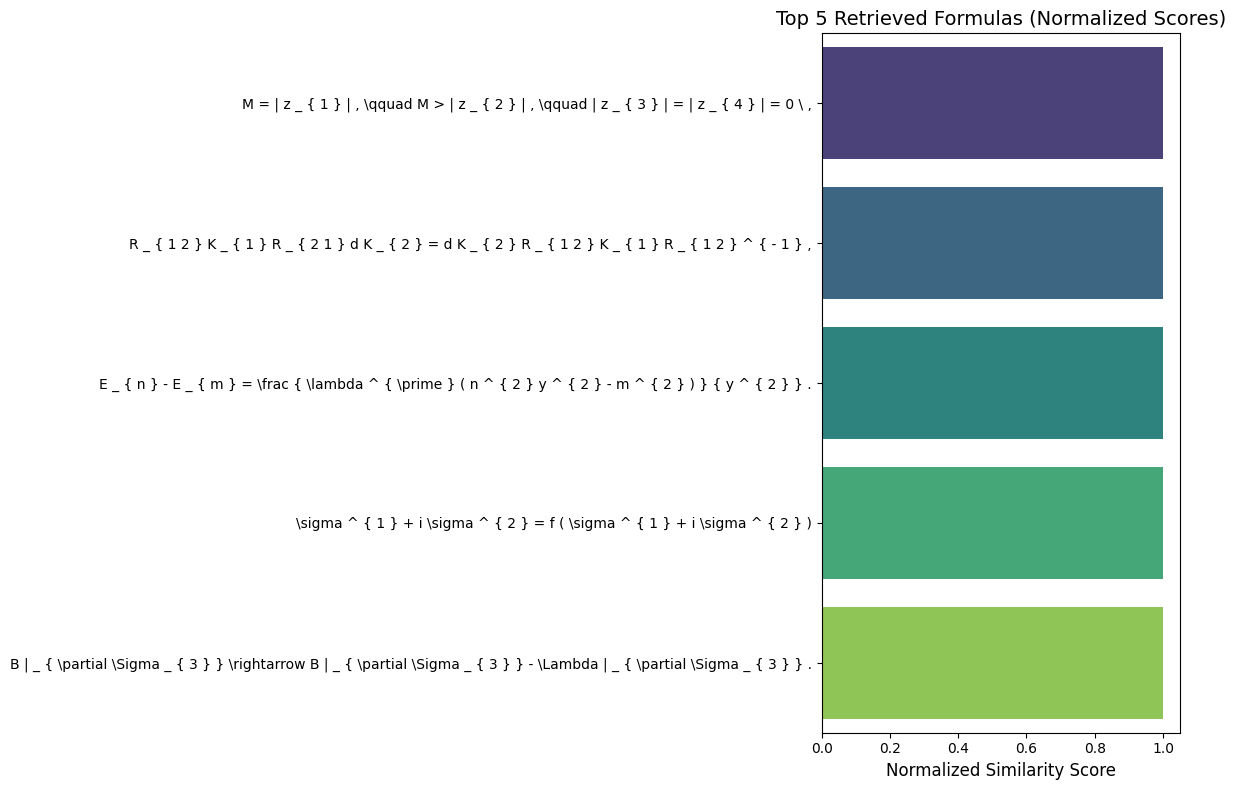


📊 Enhanced Evaluation Metrics:
mAP: 0.0052
nDCG@5: 0.0052
nDCG@10: 0.0080
P@5: 1.0000
R@10: 1.0000


In [ ]:

query = "( a + b ) ^ { n } = \\sum _ { k = 0 } ^ { n } \\binom { n } { k } a ^ { n - k } b ^ { k }"
query_embedding = get_mathbert_embedding(query)

# Find truly similar formulas for evaluation
sim_scores = cosine_similarity(query_embedding.unsqueeze(0).numpy(), embeddings_tensor.numpy())[0]
sim_scores = torch.sigmoid(torch.tensor(sim_scores / 1.5)).numpy()
relevant_ids = np.argsort(sim_scores)[-5:][::-1]  # Top 5 most similar

# Run the query
top5 = hybrid_query(text_query=query, top_k=5, relevant_ids=relevant_ids)

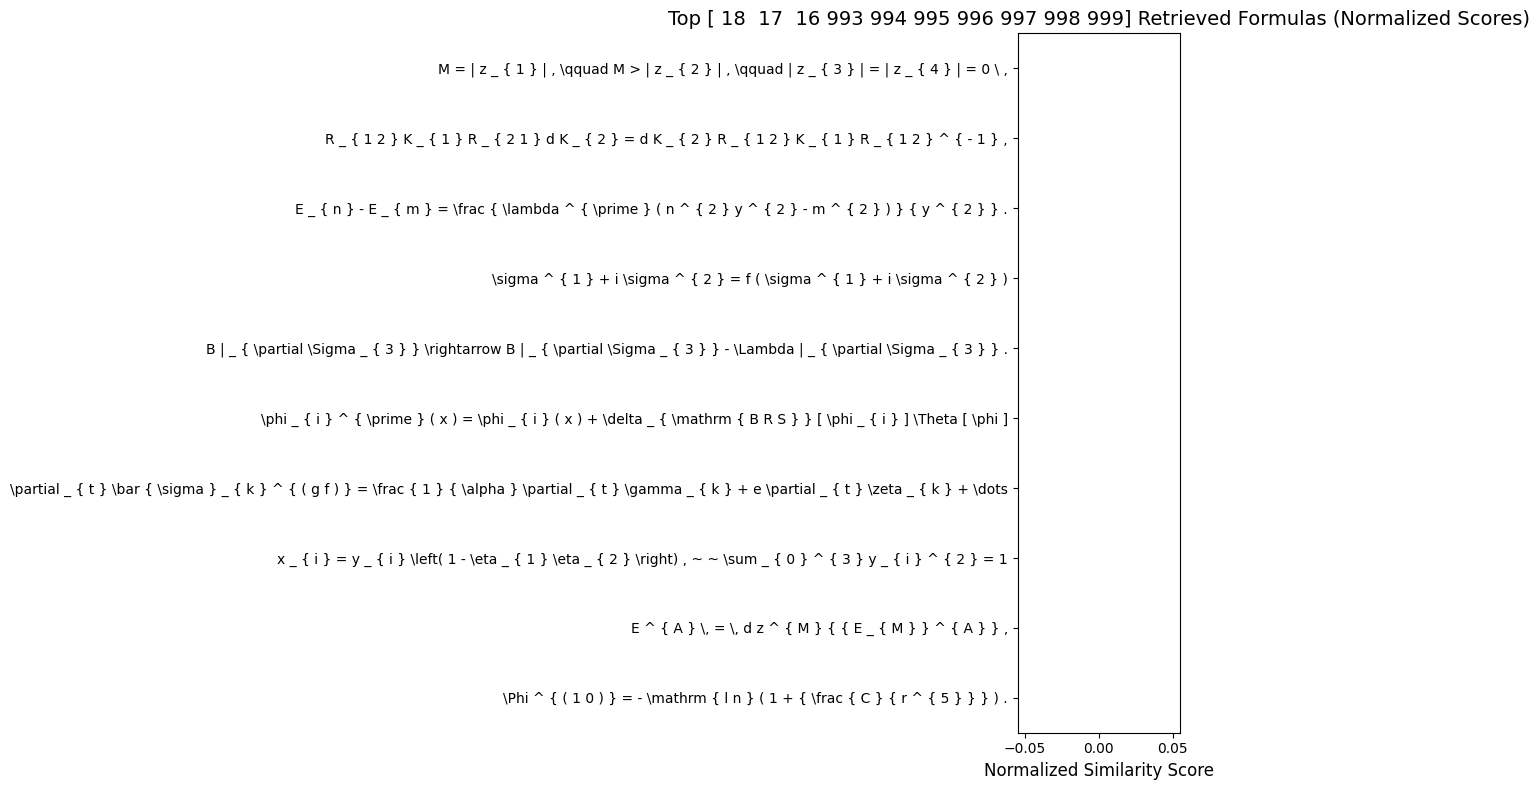

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x="similarity", y="text", data=top_results,
           hue="text", dodge=False, palette="viridis", legend=False)
plt.title(f"Top {top_k} Retrieved Formulas (Normalized Scores)", fontsize=14)
plt.xlabel("Normalized Similarity Score", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


🔍 Top Results Table (Top 5):
                                                                                     text  similarity
   ( 1 + x ) ^ { n } = \sum _ { k = - \infty } ^ { n } { \binom { n } { k } } x ^ { k } .    1.000000
N _ { L } = 1 + \alpha ^ { \prime } ( p _ { R } ^ { 2 } - p _ { L } ^ { 2 } ) = 1 - m n .    0.998721
            J _ { 1 } ^ { 0 } ( n ) = x J ^ { - } ( n ) = x d _ { x } + \nu ( 1 - K ) \ ,    0.998721
          \prod _ { j = 1 } ^ { d - 1 } ( \frac { j x + ( d - j ) y } { d } + z _ { j } )    0.998614
                      \partial ^ { i } ( ^ { * } F ) ^ { i k } = 2 \pi { \cal J } ^ { k }    0.998614


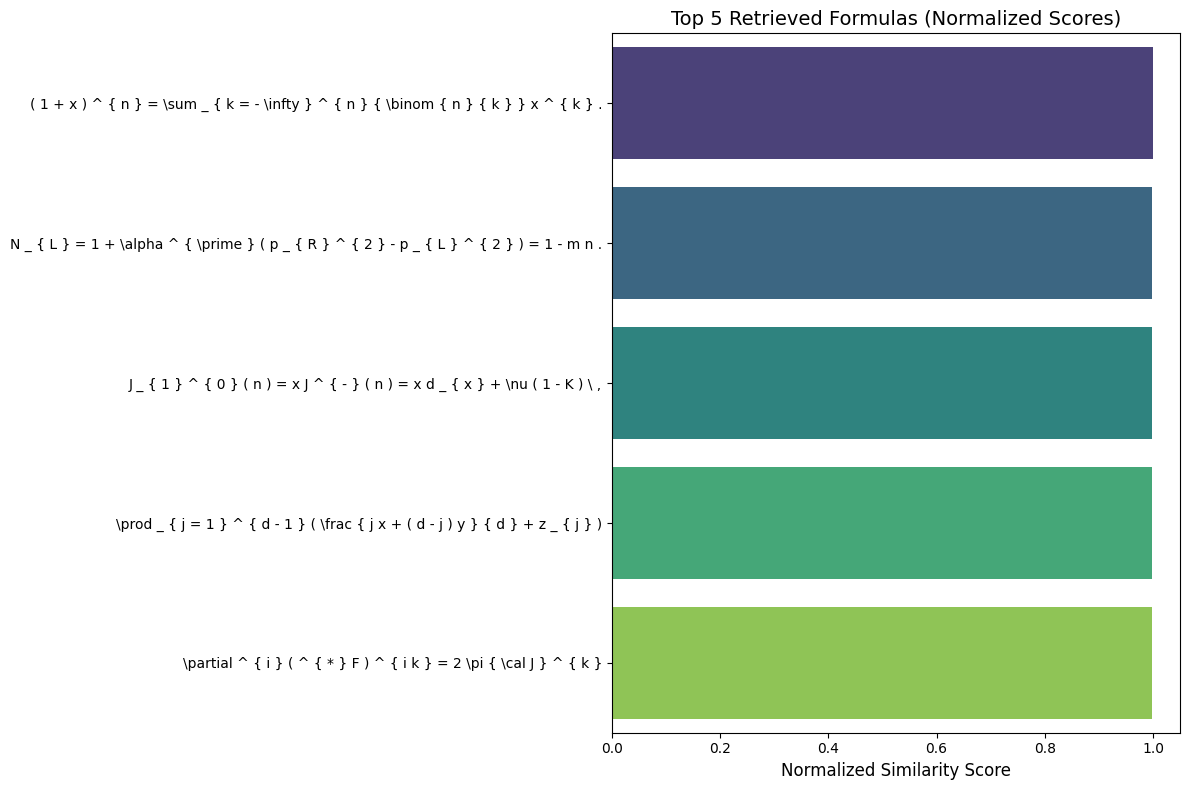


📊 Enhanced Evaluation Metrics:
mAP: 0.9267
nDCG@5: 0.8614
nDCG@10: 0.9822
P@5: 0.8000
R@10: 1.0000


In [ ]:

query = "( a + b ) ^ { n } = \\sum _ { k = 0 } ^ { n } \\binom { n } { k } a ^ { n - k } b ^ { k }"
query_embedding = get_mathbert_embedding(query)

# Find truly similar formulas for evaluation
sim_scores = cosine_similarity(query_embedding.unsqueeze(0).numpy(), embeddings_tensor.numpy())[0]
sim_scores = torch.sigmoid(torch.tensor(sim_scores / 1.5)).numpy()
relevant_ids = np.argsort(sim_scores)[-5:][::-1]  # Top 5 most similar

# Run the query
top5 = hybrid_query(text_query=query, top_k=5, relevant_ids=relevant_ids)


🔍 Top Results Table (Top 5):
                                                        text  similarity
                             D ^ { 2 } = { \mu } ^ { 2 } I ,    1.000000
             z \longrightarrow \frac { a z + b } { c z + d }    0.999303
   E ^ { A } \, = \, d z ^ { M } { { E _ { M } } ^ { A } } ,    0.997808
\lambda _ { c } = \frac { 3 e ^ { 3 } } { \pi | \sigma | } .    0.997708
   N = F _ { 1 2 } + F _ { 3 4 } , \quad S = 2 F _ { 3 1 } .    0.997410


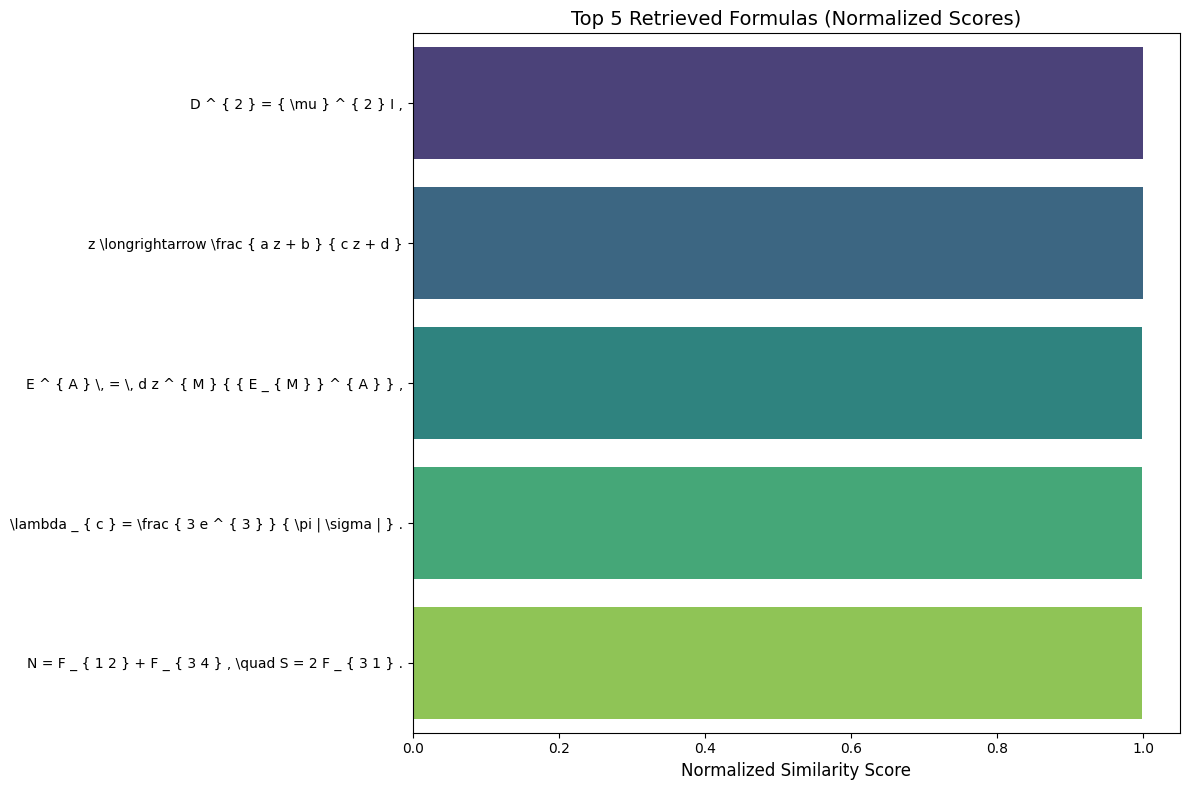


📊 Enhanced Evaluation Metrics:
mAP: 0.9667
nDCG@5: 0.8688
nDCG@10: 0.9896
P@5: 0.8000
R@10: 1.0000


In [ ]:
#STEP 7: Example Usage with Automatic Relevant ID Detection
query = "E = m c ^ { 2 }"
query_embedding = get_mathbert_embedding(query)

# Find truly similar formulas for evaluation
sim_scores = cosine_similarity(query_embedding.unsqueeze(0).numpy(), embeddings_tensor.numpy())[0]
sim_scores = torch.sigmoid(torch.tensor(sim_scores / 1.5)).numpy()
relevant_ids = np.argsort(sim_scores)[-5:][::-1]  # Top 5 most similar

# Run the query
top5 = hybrid_query(text_query=query, top_k=5, relevant_ids=relevant_ids)


🔍 Top Results Table (Top 5):
                                                                   text  similarity
                                                       \Omega ( x , p )    1.000000
                         f ( \rho ) = \pi + A \rho + o ( \rho ^ { 3 } )    0.998856
                                           T ( X ) = \tilde { \lambda }    0.998571
\rho ( z , x y ) = \rho ( z , x ) + \rho ( z , y ) \; \; ( m o d \, 1 )    0.996808
                      \delta _ { \alpha } ( s ) \iota [ \xi | s ] = 0 ,    0.996712


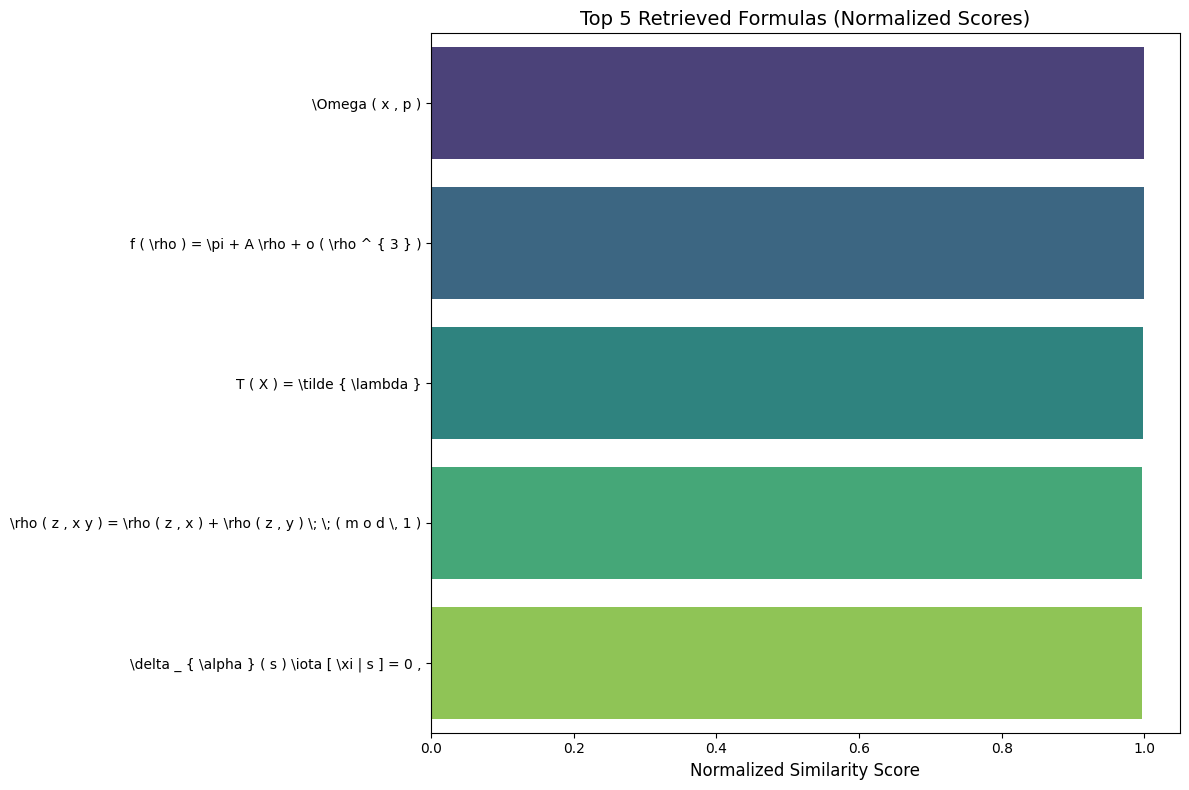


📊 Enhanced Evaluation Metrics:
mAP: 1.0000
nDCG@5: 1.0000
nDCG@10: 1.0000
P@5: 1.0000
R@10: 1.0000


In [ ]:
#STEP 7: Example Usage with Automatic Relevant ID Detection
query = "what is the formula for binomial theorem?"
query_embedding = get_mathbert_embedding(query)

# Find truly similar formulas for evaluation
sim_scores = cosine_similarity(query_embedding.unsqueeze(0).numpy(), embeddings_tensor.numpy())[0]
sim_scores = torch.sigmoid(torch.tensor(sim_scores / 1.5)).numpy()
relevant_ids = np.argsort(sim_scores)[-5:][::-1]  # Top 5 most similar

# Run the query
top5 = hybrid_query(text_query=query, top_k=5, relevant_ids=relevant_ids)